In [1]:
# standard ds imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for statistical analysis
import scipy.stats as stats

# for visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for wrangling
import wrangle
import explore

# for scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

# for feature selection verification and evaluation 
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# filter out noise
import warnings
warnings.filterwarnings('ignore')

# align markdown tables to the left

In [2]:
%%html
<style>
table {float:left}
</style>

# Zillow Regression Project

This project is designed to identify key features and build a regression model to best predict home cost. 

-----

## Executvie Summary:

Goals:
- Identify drivers of home cost
- Build a model to best predict home cost
- Minimize Root Square Mean Error (RMSE) in modeling

Key Findings:
- stuff and things
- things

Takeaways:
- stuff and things
- things

Recommendation:
- things

----

## 1. Planning

 - Create deliverables:
     - README
     - final_report.ipynb
     - working_report.ipynb
 - Build functional wrangle.py, explore.py, and model.py files
 - Acquire the data from the Code Up database via the wrangle.acquire functions
 - Prepare and split the data via the wrangle.prepare functions
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Create a baseline model in predicting home cost and document the RSME.
 - Fit and train three (3) regression models to predict cost on the train dataset.
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the train data.
 - Develop and document all findings, takeaways, recommendations and next steps. 

-----

## 2. Data Acquisition
In this step, I called my acquire_zillow function from wrangle.py. This function:
- grabs the data from the CodeUp database via a SQL query
- creates a local CSV of the table, if not already saved locally

#### Data Dictionary

| Target | Type | Description |
| ---- | ---- | ---- |
| value | int | The assessed tax value amount of the home |


| Feature Name | Type | Description |
| ---- | ---- | ---- |
| area | float | Sum of square feet in the home |
| baths | float | Count of bathrooms in the home |
| beds | float | Count of bedrooms in the home |
| decade | int | The decade the home was built in |
| half_bath | int | 1 if the home has a half bath, 0 if not |
| lat | flaot | The home's geographical latitude |
| living_space | float | The home area in sqft minus 132sqft per bedroom and 40sqft per bathroom (average sqft per respective room) |
| location | object | The human-readable county name the home is in |
| long | float | The home's geographical longitude |
| los_angeles | int | 1 if the home is in Los Angeles County, 0 if not | 
| lot_size | float | Sum of square feet of the piece of land the home is on |
| orange | int | 1 if the home is in Orange County, 0 if not |
| ventura | int | 1 if the home is in Ventura County, 0 if not|
| yard_size | float | The lot size minus the home area in sqft |
| year_built | float | The year the home was built |
| zipcode | float | The US postal service 5-digit code for the home's location |

In [3]:
# Acquire the data
zillow_data = wrangle.acquire_zillow()

In [4]:
zillow_data.shape

(52441, 10)

### Acquisition Takeaways
- The zillow data brings in 10 columns of data covering 52441 homes. 
- These homes had transactions during 2017 and are tagged as Single Family Residences.

----

## 3. Data Preparation
In this step, I called prepare_zillow from wrangle.py. This function:
- renames columns
- handles nulls and outliers
- feature engineers
- splits the data into train, validate, and test datasets
- creates a scaled DataFrame pre-set for modeling later

More specifically:
- columns are renamed to be more human readable
- drops all homes with missing data
- creates dummies for the counties (Los Angeles, Orange, and Ventura)
- removes outliers for lot_size, value, and area using quantiles
- removes a single zipcode outlier
- feature engineers:
    - decade -> bins year_built into 10 year segments
    - yard_size -> subtracts home area from the lot size
    - living_space -> subtract the average bedroom size and bathroom size from the home area
    - half_bath -> creates a True/False (1/0) tag for homes with a half bathroom

In [5]:
# Prepare the data
zillow_data = wrangle.prepare_zillow(zillow_data)

In [6]:
# Split the data into dataset. 60% for train, 20% for validate, and 20% for test
train, val, test = wrangle.split_data(zillow_data)

In [7]:
# Set the features to be scaled.
cols_to_scale = ['beds', 'baths', 'area', 'lot_size', 'year_built', 'zipcode', 'yard_size', 'living_space', 'half_bath']
# Scaled the data and assigns it to new DataFrames
train_scaled, val_scaled, test_scaled = wrangle.scale_data(train, val, test, cols_to_scale)

### Preparation Takeaways
- I feature engineered yard_size and living_space to better assess the aspect ratio of these features. More yard or living area may play a role in home value. 
- I feature engineered decades for the purpose of visualization during explore
- I feature engineered half_bath to isolate homes with this feature. 
- Before moving to exploration, I split the data into train, validate, and test datasets. Lastly, I created scaled versions of these datasets in preparation for modeling.

----

## 4. Data Exploration

### Question 1: Do larger homes have more value?

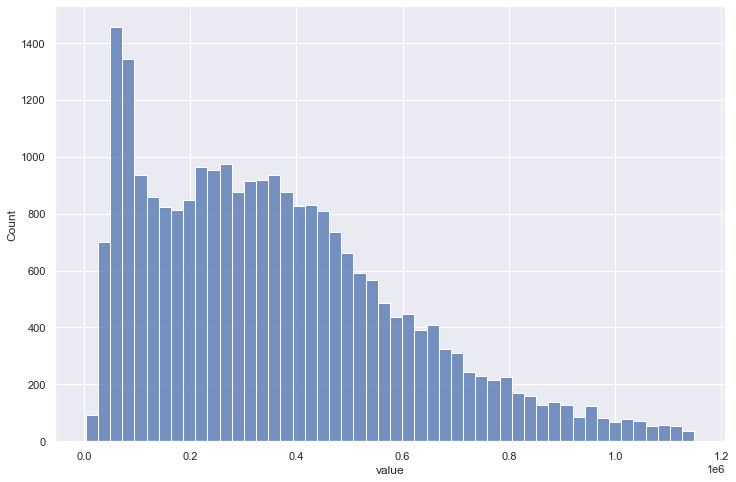

In [19]:
plt.figure(figsize=(12,8))
sns.histplot(data=train, x='value')
plt.show()

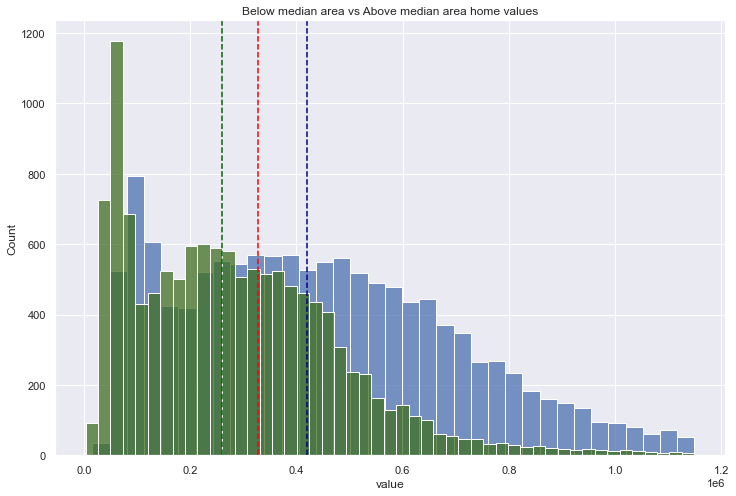

In [108]:
plt.figure(figsize=(12,8))

sns.histplot(data=train[train.area > train.area.median()], x='value')
sns.histplot(data=train[train.area <= train.area.median()], x='value', color='#3f6f21')

above = train[train.area > train.area.median()].value.median()
plt.axvline(x=above, color='darkblue', linestyle='--')
below = train[train.area <= train.area.median()].value.median()
plt.axvline(x=below, color='darkgreen', linestyle='--')
middle = train.value.median()
plt.axvline(x=middle, color='red', linestyle='--')

plt.title('Below median area vs Above median area home values')
plt.show()

#### Hypothesis 1:
- Ho1 -> Homes with above median area have less than or equal value to homes with below median area
- Ha1 -> Homes with above median area have greater value to homes with below median area

T-Test: Two-Sample, One-Tail

In [11]:
# Create the samples
area_above = train[train.area > train.area.median()].value
area_below = train[train.area <= train.area.median()].value

# Set alpha
α = 0.05

# Check for equal variances
s, pval = stats.levene(area_above, area_below)

# Run the two-sample, one-tail T-test.
# Use the results from checking for equal variances to set equal_var
t, p = stats.ttest_ind(area_above, area_below, equal_var=(pval >= α))

# Evaluate results based on the t-statistic and the p-value
if p/2 < α and t > 0:
    print('''Reject the Null Hypothesis.
Findings suggest there is more value in homes with above median area than homes with below median area.''')
else:
    print('''Fail to reject the Null Hypothesis.
Findings sugget there is more value in homes with below median area than homes with above medain area.''')

Reject the Null Hypothesis.
Findings suggest there is more value in homes with above median area than homes with below median area.


#### Question 1 Takeaways:
- There is more value in homes with above median value.

----

### Question 2: Is there more value in bedrooms or bathrooms?

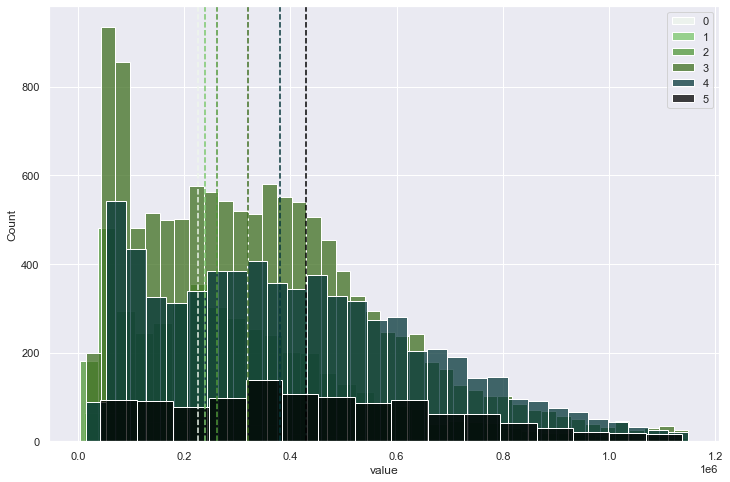

In [93]:
plt.figure(figsize=(12,8))
sns.histplot(data=train[train.beds == 0], x='value', label = 0, color='#eef6ec')
plt.axvline(x=train[train.beds == 0].value.median(), color='#eef6ec', linestyle='--')
sns.histplot(data=train[train.beds == 1], x='value', label = 1, color='#7bc86c')
plt.axvline(x=train[train.beds == 1].value.median(), color='#7bc86c', linestyle='--')
sns.histplot(data=train[train.beds == 2], x='value', label = 2, color='#519839')
plt.axvline(x=train[train.beds == 2].value.median(), color='#519839', linestyle='--')
sns.histplot(data=train[train.beds == 3], x='value', label = 3, color='#3f6f21')
plt.axvline(x=train[train.beds == 3].value.median(), color='#3f6f21', linestyle='--')
sns.histplot(data=train[train.beds == 4], x='value', label = 4, color='#06373A')
plt.axvline(x=train[train.beds == 4].value.median(), color='#06373A', linestyle='--')
sns.histplot(data=train[train.beds == 5], x='value', label = 5, color='black')
plt.axvline(x=train[train.beds == 5].value.median(), color='black', linestyle='--')

# plt.ylim(0,600)

plt.legend()
plt.show()

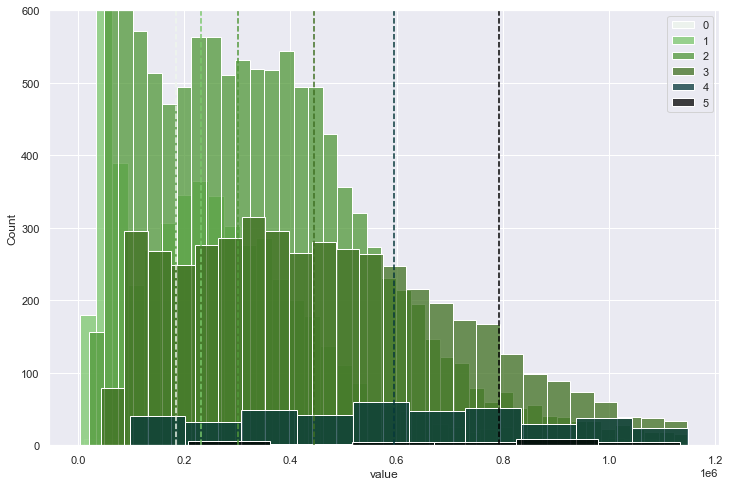

In [94]:
plt.figure(figsize=(12,8))
sns.histplot(data=train[train.baths == 0], x='value', label = 0, color='#eef6ec')
plt.axvline(x=train[train.baths == 0].value.median(), color='#eef6ec', linestyle='--')
sns.histplot(data=train[train.baths == 1], x='value', label = 1, color='#7bc86c')
plt.axvline(x=train[train.baths == 1].value.median(), color='#7bc86c', linestyle='--')
sns.histplot(data=train[train.baths == 2], x='value', label = 2, color='#519839')
plt.axvline(x=train[train.baths == 2].value.median(), color='#519839', linestyle='--')
sns.histplot(data=train[train.baths == 3], x='value', label = 3, color='#3f6f21')
plt.axvline(x=train[train.baths == 3].value.median(), color='#3f6f21', linestyle='--')
sns.histplot(data=train[train.baths == 4], x='value', label = 4, color='#06373A')
plt.axvline(x=train[train.baths == 4].value.median(), color='#06373A', linestyle='--')
sns.histplot(data=train[train.baths == 5], x='value', label = 5, color='black')
plt.axvline(x=train[train.baths == 5].value.median(), color='black', linestyle='--')


plt.ylim(0,600)

plt.legend()
plt.show()

#### Hypothesis 2: 
- Ho2 -> Homes with above median bathrooms and below median bedrooms have a lower or equal value than homes with below median bathrooms and above median bedrooms.
- Ha2 -> Homes with above median bathrooms and below median bedrooms have a greater value than homes with below median bathrooms and above median bedrooms.

T-Test: Two-Sample, One-Tail

In [15]:
# Create the samples
baths_above = train[(train.baths > train.baths.median())&(train.beds < train.beds.median())].value
baths_below = train[(train.baths < train.baths.median())&(train.beds > train.beds.median())].value

# Set alpha
α = 0.05

# Check for equal variances
s, pval = stats.levene(baths_above, baths_below)

# Run the two-sample, one-tail T-test.
# Use the results from checking for equal variances to set equal_var
t, p = stats.ttest_ind(baths_above, baths_below, equal_var=(pval >= α))

# Evaluate results based on the t-statistic and the p-value
if p/2 < α and t > 0:
    print('''Reject the Null Hypothesis.
Findings suggest there is more value in homes with above median bathrooms and below median bedrooms than homes with below median bathrooms and above median bedrooms.''')
else:
    print('''Fail to reject the Null Hypothesis.
Findings suggest there is more value in homes with below median bathrooms and above median bedrooms than homes with above median bathrooms and below median bedrooms.''')

Reject the Null Hypothesis.
Findings suggest there is more value in homes with above median bathrooms and below median bedrooms than homes with below median bathrooms and above median bedrooms.


### Question 2b: Is the number of bathrooms and bedrooms related?

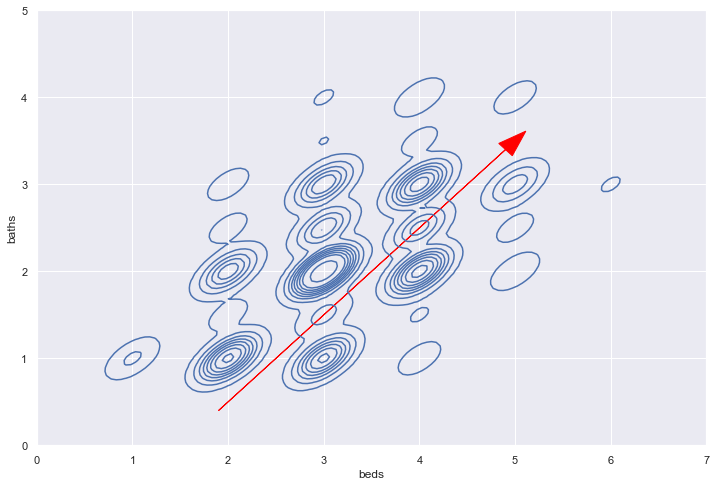

In [107]:
plt.figure(figsize=(12,8))

sns.kdeplot(data=train, x='beds', y='baths')
plt.xlim(0,7)
plt.ylim(0,5)
plt.arrow(1.9,.4,3,3, head_width=.2, color='red')
plt.show()

#### Hypothesis 2b:
- Ho2b -> There is not an association between bedrooms and bathrooms.
- Ha2b -> There is an association between bedrooms and bathrooms.

Chi-Square Test: Bedrooms vs Bathrooms

In [16]:
# Set alpha
α = 0.05

# Create observed data
observed = pd.crosstab(train.beds, train.baths)

# Run chi-square test
chi2,pval,degf,expected = stats.chi2_contingency(observed)

# Evaluate results by comparing the p-value with alpha
if p < α:
    print('''Reject the Null Hypothesis.
Findings suggest there is an association between bedrooms and bathrooms.''')
else:
    print('''Fail to reject the Null Hypothesis.
Findings suggest there is not an association between bedrooms and bathrooms.''')

Reject the Null Hypothesis.
Findings suggest there is an association between bedrooms and bathrooms.


#### Question 2 Takeaways:
- There is more value in homes with above median bathrooma and below median bedrooms than the opposite. 
- There is an association between bedrooms and bathrooms.

----

### Question 3: What is location's role in home value?

In [115]:
train['brackets'] = pd.cut(train.value, 10, labels=[1,2,3,4,5,6,7,8,9,10])

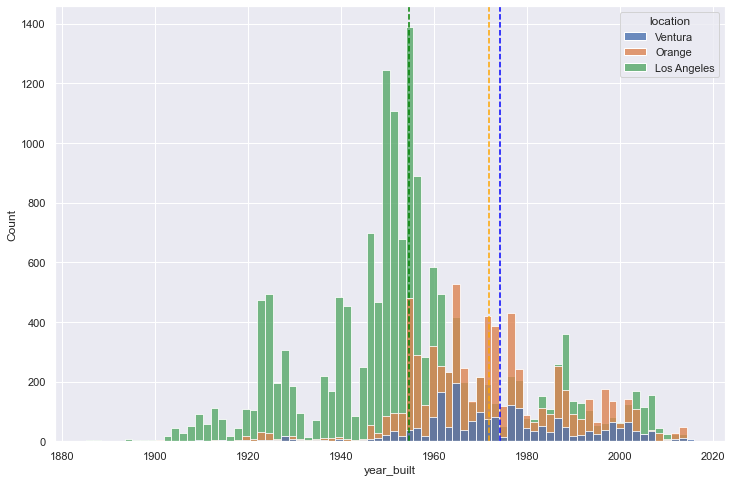

In [150]:
plt.figure(figsize=(12,8))
sns.histplot(data=train, x='year_built', alpha=.8, hue='location',hue_order=['Ventura', 'Orange', 'Los Angeles'])
plt.axvline(x=train[train.location == 'Los Angeles'].year_built.mean(), color='green', linestyle='--')
plt.axvline(x=train[train.location == 'Orange'].year_built.mean(), color='orange', linestyle='--')
plt.axvline(x=train[train.location == 'Ventura'].year_built.mean(), color='blue', linestyle='--')
plt.show()

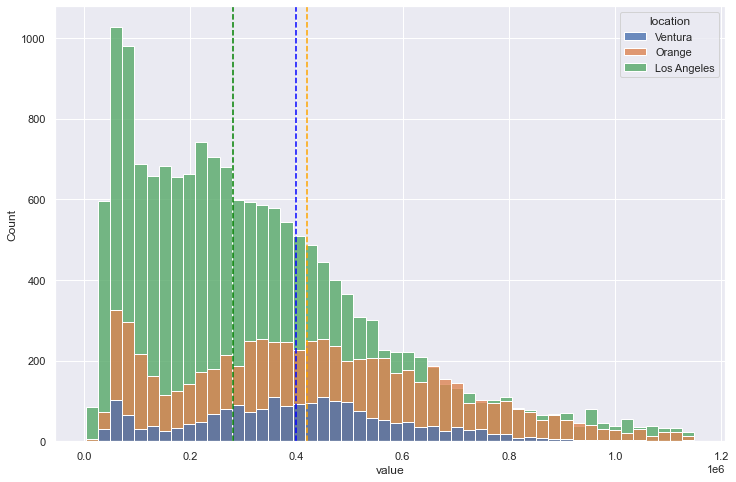

In [147]:
plt.figure(figsize=(12,8))
sns.histplot(data=train, x='value', alpha=.8, hue='location', hue_order=['Ventura', 'Orange', 'Los Angeles'])
plt.axvline(x=train[train.location == 'Los Angeles'].value.median(), color='green', linestyle='--')
plt.axvline(x=train[train.location == 'Orange'].value.median(), color='orange', linestyle='--')
plt.axvline(x=train[train.location == 'Ventura'].value.median(), color='blue', linestyle='--')
plt.show()

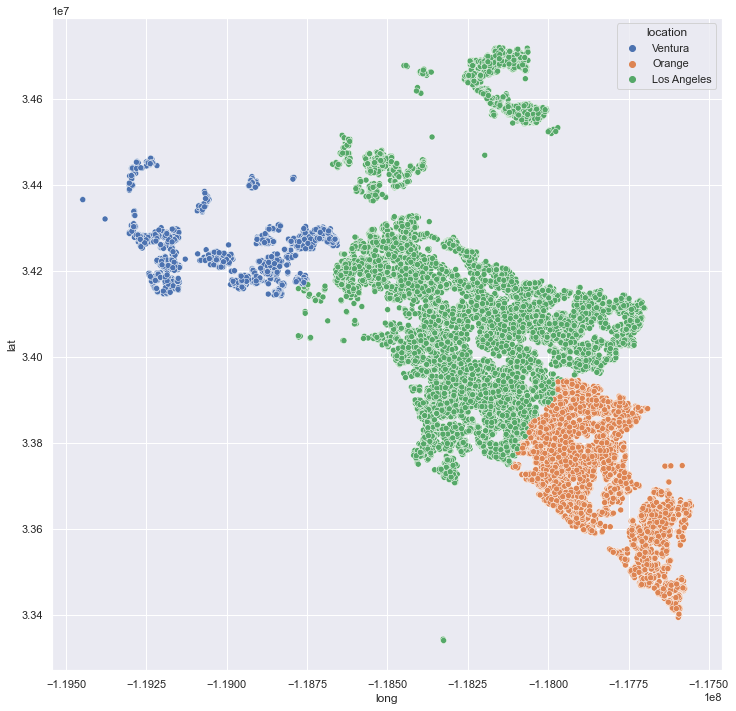

In [149]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=train, x='long', y='lat', hue='location', hue_order=['Ventura', 'Orange', 'Los Angeles'])
plt.show()

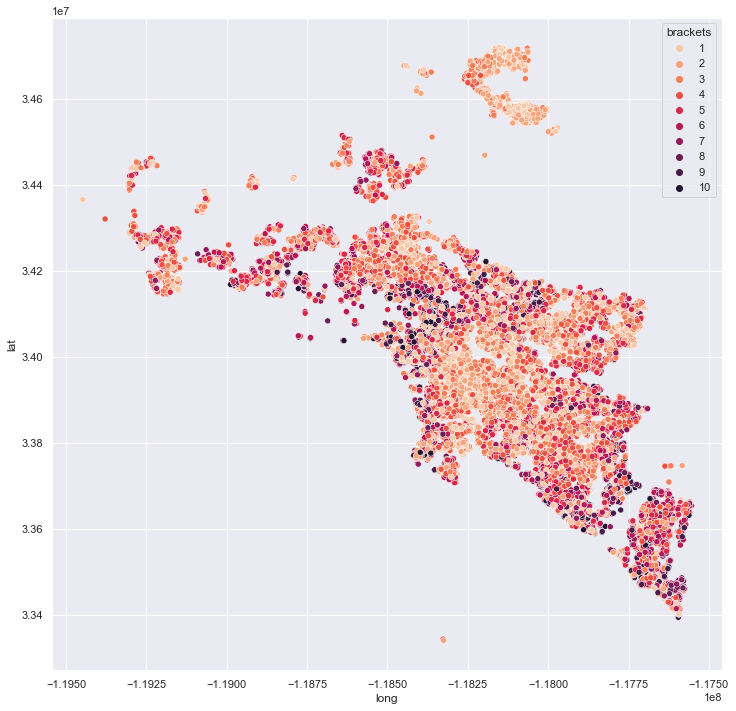

In [141]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=train, x='long', y='lat', hue='brackets', palette='rocket_r')
plt.show()